In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from mord import LogisticIT
from dmba.metric import AIC_score
from dmba import classificationSummary
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

%matplotlib inline

In [102]:
fraud = pd.read_csv('Online Payments Fraud.csv')
fraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [103]:
#Getting familiar with data

fraud.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [104]:
# Checking the NA Values

fraud.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [105]:
fraud.dropna(inplace = True)

In [106]:
#Knowing the data types of the columns

fraud.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [107]:
#Changing class type variables to object

fraud['isFraud'] = fraud['isFraud'].astype('int')

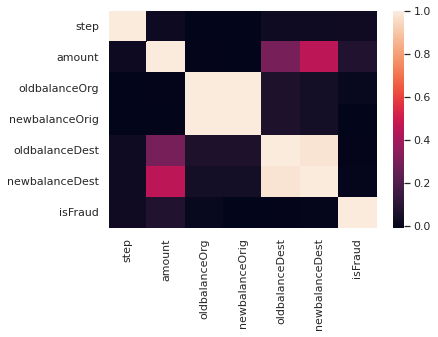

In [108]:
corr_mat = fraud[['step','type','amount','nameOrig','oldbalanceOrg',
               'newbalanceOrig','nameDest','oldbalanceDest',
               'newbalanceDest','isFraud']].corr()
sns.heatmap(corr_mat)

In [109]:
fraud.isFraud.value_counts() / len(fraud) * 100

0    99.870918
1     0.129082
Name: isFraud, dtype: float64

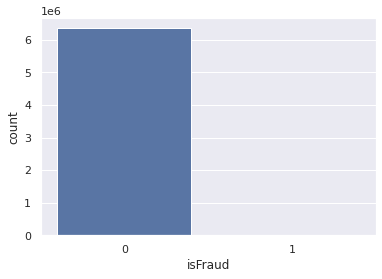

In [110]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="isFraud", data=fraud)

In [111]:
fraud.isFlaggedFraud.value_counts() / len(fraud) * 100

0    99.999749
1     0.000251
Name: isFlaggedFraud, dtype: float64

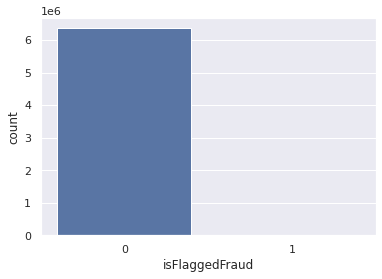

In [112]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="isFlaggedFraud", data=fraud)

In [113]:
fraud.drop(['isFlaggedFraud'], inplace = True, axis=1)

In [114]:
fraud.type.value_counts() / len(fraud) * 100

CASH_OUT    35.166331
PAYMENT     33.814608
CASH_IN     21.992261
TRANSFER     8.375622
DEBIT        0.651178
Name: type, dtype: float64

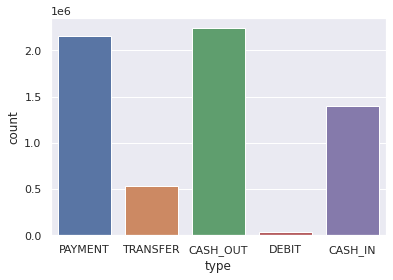

In [115]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="type", data=fraud)

In [116]:
fraud.groupby('isFraud').type.value_counts() / len(fraud) * 100

isFraud  type    
0        CASH_OUT    35.101641
         PAYMENT     33.814608
         CASH_IN     21.992261
         TRANSFER     8.311230
         DEBIT        0.651178
1        CASH_OUT     0.064690
         TRANSFER     0.064392
Name: type, dtype: float64

In [117]:
fraud = fraud.loc[fraud['type'].isin(['CASH_OUT','TRANSFER']),:]
print('The updated data now has', len(fraud), 'transactions.')

The updated data now has 2770409 transactions.


In [118]:
print('Number of transactions where amount is negative: ' + 
      str(sum(fraud['amount'] < 0)))

Number of transactions where amount is negative: 0


In [119]:
print('Number of transactions where amount is zero: ' + 
      str(sum(fraud['amount'] == 0)))

Number of transactions where amount is zero: 16


In [120]:
fraud = fraud.loc[fraud['amount'] > 0, :]
print('The updated data now has', len(fraud), 'transactions.')

The updated data now has 2770393 transactions.


In [121]:
fraud['origBalance_inacc'] = (fraud['oldbalanceOrg'] - fraud['amount']) - fraud['newbalanceOrig']
fraud['destBalance_inacc'] = (fraud['oldbalanceDest'] + fraud['amount']) - fraud['newbalanceDest']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [122]:
fraud.drop(['nameOrig', 'nameDest'], inplace = True, axis=1)

In [123]:
fraud = pd.get_dummies(fraud, columns = ['type'])

In [124]:
fraud['type_CASH_OUT'] = fraud['type_CASH_OUT'].astype('int')
fraud['type_TRANSFER'] = fraud['type_TRANSFER'].astype('int')

In [125]:
fraud.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,origBalance_inacc,destBalance_inacc,type_CASH_OUT,type_TRANSFER
2,1,181.00,181.0,0.0,0.0,0.00,1,0.00,181.0,0,1
3,1,181.00,181.0,0.0,21182.0,0.00,1,0.00,21363.0,1,0
15,1,229133.94,15325.0,0.0,5083.0,51513.44,0,-213808.94,182703.5,1,0
19,1,215310.30,705.0,0.0,22425.0,0.00,0,-214605.30,237735.3,0,1
24,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,-300850.89,-2401220.0,0,1


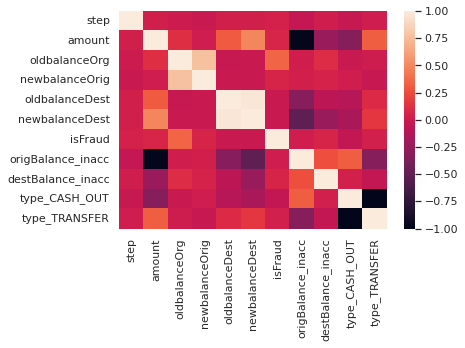

In [126]:
corr_mat = fraud[['step','amount','oldbalanceOrg','newbalanceOrig',
                  'oldbalanceDest','newbalanceDest','isFraud',
                  'origBalance_inacc','destBalance_inacc','type_CASH_OUT',
                  'type_TRANSFER']].corr()
sns.heatmap(corr_mat)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


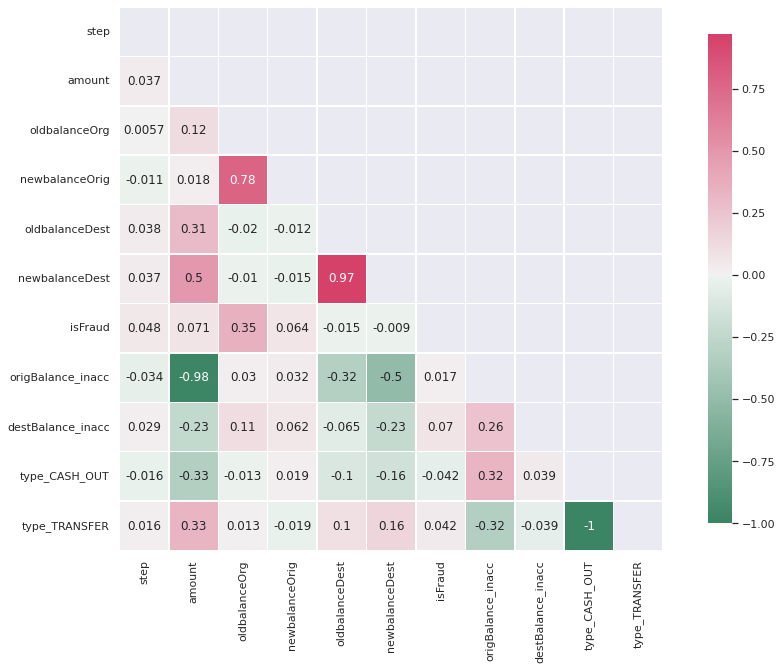

In [127]:
corr = fraud.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(16, 10))
cmap = sns.diverging_palette(150, 1, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

In [128]:
X = fraud.drop(columns = ['isFraud'])
y = fraud['isFraud']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state = 1)

In [129]:
print('Training   : ', X_train.shape,y_train.shape)
print('Test       : ', X_test.shape,y_test.shape)

Training   :  (1939275, 10) (1939275,)
Test       :  (831118, 10) (831118,)


In [130]:
ros = RandomOverSampler(sampling_strategy = 'auto', random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [131]:
y_resampled.value_counts()

0    1933620
1    1933620
Name: isFraud, dtype: int64

In [132]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
def model_validation(y_test,y_predicted):
  print('Accuracy Score:',accuracy_score(y_test,y_predicted))
  print('F1 Score:', f1_score(y_test,y_predicted))
  print('Precision Score:', precision_score(y_test, y_predicted ))
  print('Recall Score:', recall_score(y_test,y_predicted))

In [133]:
def classification_matrix(y_test,y_predicted):
#Generate the confusion matrix
  cf_matrix = confusion_matrix(y_test, y_predicted)



  ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

  ax.set_title('Seaborn Confusion Matrix with labels\n\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['Not Fraud','Fraud'])
  ax.yaxis.set_ticklabels(['Not Fraud','Fraud'])

  ## Display the visualization of the Confusion Matrix.
  plt.show()

Accuracy Score: 0.9999795456240871
F1 Score: 0.9966528844260681
Precision Score: 0.9976350019708317
Recall Score: 0.9956726986624705


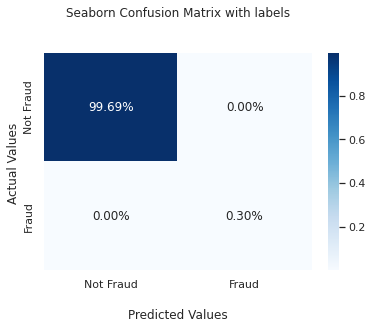

In [134]:
#Decision Tree Classifier


model_dt = DecisionTreeClassifier(random_state = 1)
model_dt.fit(X_resampled, y_resampled)

y_pred_dt = model_dt.predict(X_test)

model_validation(y_test,y_pred_dt)
classification_matrix(y_test,y_pred_dt)

In [135]:
# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(X_resampled, y_resampled)

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(y_test, logit_reg.predict(X_test), df = len(X_train.columns) + 1))

intercept  -5.736969431625143e-10
               step    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
coeff -2.956569e-09  0.000003        0.00001       -0.000011        0.000004   

       newbalanceDest  origBalance_inacc  destBalance_inacc  type_CASH_OUT  \
coeff       -0.000005           0.000018           0.000011  -8.297223e-10   

       type_TRANSFER  
coeff   2.560254e-10  

AIC 533467.2310032197


In [136]:
logit_reg_pred = logit_reg.predict(X_test)
logit_reg_proba = logit_reg.predict_proba(X_test)
logit_result = pd.DataFrame({'actual': y_test, 
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

print(logit_result)

         actual      p(0)          p(1)  predicted
3413712       0  0.656827  3.431726e-01          0
87438         0  0.630698  3.693023e-01          0
2251312       0  0.963454  3.654552e-02          0
2985085       0  0.927908  7.209242e-02          0
103959        0  1.000000  9.276304e-10          0
...         ...       ...           ...        ...
3159912       0  0.686980  3.130203e-01          0
2465610       0  0.999728  2.720038e-04          0
5343110       0  1.000000  2.484911e-08          0
3785614       0  0.851498  1.485023e-01          0
5885170       0  0.851497  1.485027e-01          0

[831118 rows x 4 columns]


In [137]:
classificationSummary(y_train, logit_reg.predict(X_train))
classificationSummary(y_test, logit_reg.predict(X_test))

Confusion Matrix (Accuracy 0.8887)

       Prediction
Actual       0       1
     0 1717954  215666
     1     141    5514
Confusion Matrix (Accuracy 0.8888)

       Prediction
Actual      0      1
     0 736190  92386
     1     70   2472


Accuracy Score: 0.8887570717996722
F1 Score: 0.05075975359342916
Precision Score: 0.026060005481878177
Recall Score: 0.9724626278520849


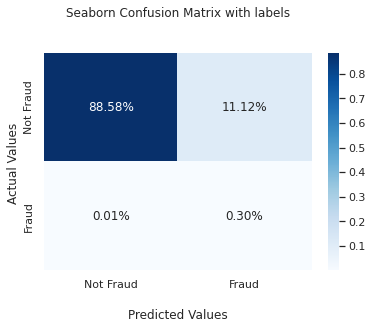

In [138]:

model_dt = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
model_dt.fit(X_resampled, y_resampled)

y_pred_dt = model_dt.predict(X_test)

model_validation(y_test,y_pred_dt)
classification_matrix(y_test,y_pred_dt)

Accuracy Score: 0.9999867648155858
F1 Score: 0.997832512315271
Precision Score: 0.9996052112120016
Recall Score: 0.996066089693155


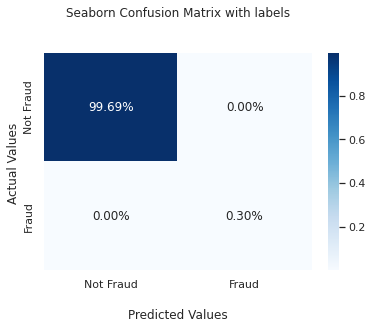

In [139]:
model_rfc = RandomForestClassifier(random_state = 1)
model_rfc.fit(X_resampled, y_resampled)

y_pred_rfc = model_rfc.predict(X_test)

model_validation(y_test,y_pred_rfc)
classification_matrix(y_test,y_pred_rfc)

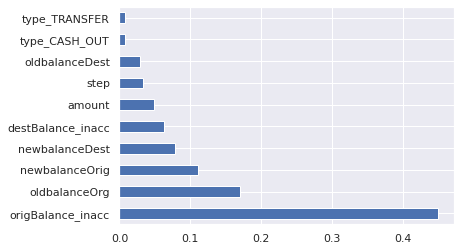

In [142]:
PE = fraud.drop(columns = ['isFraud'])

feat_importances = pd.Series(model_rfc.feature_importances_, index=PE.columns)
feat_importances.nlargest(15).plot(kind="barh")
plt.show()